In [1]:
import numpy as np
import math
np.set_printoptions(precision=4, suppress=True, linewidth=10000)
import matplotlib.pyplot as plt


In [2]:
popsize = 2000  #10 for the time being
d = [0.2, 0.2]
v = 10
C = 2
L = float('inf')
mut = 0.01
mutsize = 0.1
initmean = [0, 0, 0]
shared = False
generations = 10001
bug_fix_who_encounter = True
bug_fix_offspring = True

In [3]:
def emergencesample(T):
    p = np.random.rand(*T.shape)
    sample = T + np.log(p / (1 - p))
    return sample

Old code



In [4]:
#secondary parameters

v = v / (popsize / 2)  # to make the situation comparable with the assumptions in the numerical stuff
warning = 0  # so far no warnings found that 'trackmatings' below is too long
extinction_status = 0  # 0 = no extinction, 1 = extinction

# initialize the population
# 'sex=0' simply defines that 1st column will sex (where we will use the notation -1 = male, +1 = female)
sex = 0



sa = np.array([1, 2])
ma = np.array([3, 4])
fa = np.array([5, 6])  # these are indices for: shared alleles, male alleles, female alleles
maledeathrate = d[0]
femaledeathrate = d[1]



if shared:
        mel = np.concatenate((sa, ma))  # mel stands for male-expressed loci
        fel = np.concatenate((sa, fa))  # fel stands for female-expressed loci
else:
        mel = ma
        fel = fa

# run one mating season
# figure out when each individual emerges (according to their timing phenotype)

trackmatings = popsize# number of matings we track for a female - if she's mated with >20 males and the first 20 are all sperm depleted this is a potential problem, in that case please increase this value


t_for_axis = np.arange(0, generations, 10)

#will need to thik abit his
shape = (int((generations - 1)/ 10 + 1), 4)
data = np.full(shape, np.nan)



In [5]:
def emergencesample(T):
    p = np.random.rand(*T.shape)
    sample = T + np.log(p / (1 - p))
    return sample

In [6]:
def initialise_population(popsize, initmean, sa, ma, fa):

        pop = np.sign(np.random.randn(1, popsize))

        # columns 2-3 are shared alleles, 4-5 male alleles, 6-7 female alleles


        # pop[sa[0]:fa[1], :] = np.random.normal(6, popsize)

        # pop[1:6, :] = np.random.normal(0, 1, size=(6, popsize))
        pop = np.vstack([pop, np.random.normal(0, 1, size=(6, popsize))])

        pop[sa[0:1], :] += initmean[0]
        pop[ma[0:1], :] += initmean[1]
        pop[fa[0:1], :] += initmean[2]

        return pop

In [7]:
def population_phenotypes(pop):

    phenotype = (pop[sex, :] < 0) * np.mean(pop[mel, :], axis = 0) + (pop[sex, :] > 0) * np.mean(pop[fel, :], axis = 0)
    return phenotype

def population_deathtime(emergencetime, pop):

    deathtime = emergencetime + ((pop[sex, :] < 0) * np.random.exponential(scale=1/maledeathrate, size=popsize) +
                                  (pop[sex, :] > 0) * np.random.exponential(scale=1/femaledeathrate, size=popsize))

    return deathtime

In [8]:
def track_encounter_for_population(pop, emergencetime, deathtime):


    f = np.where(pop[sex, :] > 0)[0]
    m = np.where(pop[sex, :] < 0)[0]


    T_encounter = np.full((trackmatings, popsize), np.nan)
    who_encounter = np.full((trackmatings, popsize), np.nan)
    

    for i in range(len(f)):
        t_encounter = np.maximum(emergencetime[f[i]], emergencetime) + np.random.exponential(scale=1/v, size=popsize)


        t_encounter[pop[sex, :] > 0] = np.nan
        t_encounter[t_encounter > deathtime[f[i]]] = np.nan
        t_encounter[(t_encounter > deathtime) & (pop[sex, :] < 0)] = np.nan

        sorted_indices = np.argsort(t_encounter)
        sorted_t_encounter = t_encounter[sorted_indices]
        sorted_whichmale = sorted_indices[:trackmatings]
        T_encounter[:trackmatings, f[i]] = sorted_t_encounter[:trackmatings]
        
        who_encounter[:trackmatings, f[i]] = sorted_whichmale[:trackmatings]

        flag = np.where(~np.isnan(T_encounter[-1, :]))[0]


    return T_encounter, who_encounter, flag

    # this function returns the

In [9]:
def mating_assignment_population(pop, T_encounter, who_encounter, flag):

    matecount = np.zeros(popsize)
    mateidentity = np.full(popsize, np.nan)
    relativefecundity = np.zeros(popsize)

    while np.any(~np.isnan(T_encounter[0, :])):
        ind = np.nanargmin(T_encounter[0, :])
        time = T_encounter[0, ind]
        male = int(who_encounter[0, ind])


        if matecount[male] < C:
            T_encounter[:, ind] = np.nan
            matecount[male] += 1
            mateidentity[ind] = male
            relativefecundity[ind] = 400 * np.exp(time / L) / (1 + np.exp(time / L))**2

        else:
            T_encounter[:, ind] = np.concatenate((T_encounter[1:, ind], [np.nan]))
            if bug_fix_who_encounter:
                who_encounter[:, ind] = np.concatenate((who_encounter[1:, ind], [np.nan]))

    global warning

    if len(flag) > 0 and np.any(relativefecundity[flag] == 0):
        warning = 1
    
    global extinction_status
    
    if np.sum(relativefecundity) == 0:
        extinction_status = 1

    return mateidentity, relativefecundity, warning, extinction_status

In [10]:
def data_collection(data, k, pop, relativefecundity, mateidentity):

    mean_male_time = np.mean(np.mean(pop[mel, :][:, pop[sex, :] < 0], axis = 0))
    mean_female_time = np.mean(np.mean(pop[fel, :][:, pop[sex, :] > 0], axis = 0))

    if len(relativefecundity[relativefecundity > 0]):
            mean_fecundity = np.mean(relativefecundity[relativefecundity > 0])
    else:
            mean_fecundity = 0
            print("extinction")
               
    matelessness = 1 - (np.sum(~np.isnan(mateidentity)) / np.sum(pop[sex, :] > 0))


    data[int((k-1)/10), :] = [mean_male_time, mean_female_time, mean_fecundity, matelessness]
    
    return data

In [11]:
def plotting(data, warning, k):
    
    plt.figure(1)

    plt.subplot(3, 1, 1)
    plt.plot(t_for_axis, data[:, 0], 'b', t_for_axis, data[:, 1], 'r')
    plt.ylabel('Timing')
    plt.title('Warning status: {}'.format(int(warning)))  # Assuming 'warning' is defined
    plt.subplot(3, 1, 2)
    plt.plot(t_for_axis, data[:, 2], 'g')
    plt.ylabel('fecundity')
    plt.subplot(3, 1, 3)
    plt.plot(t_for_axis, data[:, 3], 'k')
    plt.ylabel('matelessness')

    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.show() 

    print("generation", k)

In [12]:
def offspring_population(pop, mateidentity, relativefecundity):

    fecundity_probability = [x / sum(relativefecundity) for x in relativefecundity]
    mother = np.random.choice(popsize, popsize, p=fecundity_probability, replace=True)
    sire = [int(mateidentity[x]) for x in mother]

    offspring = np.sign(np.random.randn(1, popsize))
    offspring = np.vstack([offspring, np.random.normal(0, 1, size=(6, popsize))]) #just randomly assigning. It will be replaced to NaN
    offspring[sa[0]:fa[1]+1, :] = np.nan

    whichallele_egg = np.random.randint(2, size=(3, popsize))
    whichallele_sperm = np.random.randint(2, size=(3, popsize))


    for i in range(popsize):
    # Each female produces one clutch of offspring
    
        # Offspring traits inherited from mother's egg
        offspring[sa[0], i] = pop[sa[0] + whichallele_egg[0, i], mother[i]]
        offspring[ma[0], i] = pop[ma[0] + whichallele_egg[1, i], mother[i]]
        offspring[fa[0], i] = pop[fa[0] + whichallele_egg[2, i], mother[i]]
        
        # Offspring traits inherited from father's sperm
        offspring[sa[1], i] = pop[sa[0] + whichallele_sperm[0, i], sire[i]]
        offspring[ma[1], i] = pop[ma[0] + whichallele_sperm[1, i], sire[i]]
        offspring[fa[1], i] = pop[fa[0] + whichallele_sperm[2, i], sire[i]]


    # print(pop, "pop as in dad")

    pop[sa[0]:fa[1]+1, :] = offspring[sa[0]:fa[1]+1, :] + (np.random.rand(6, popsize) < mut) * mutsize * np.random.randn(1, popsize)
    
    if bug_fix_offspring:
    
        pop[0,:] = offspring[0, :]

    return pop 

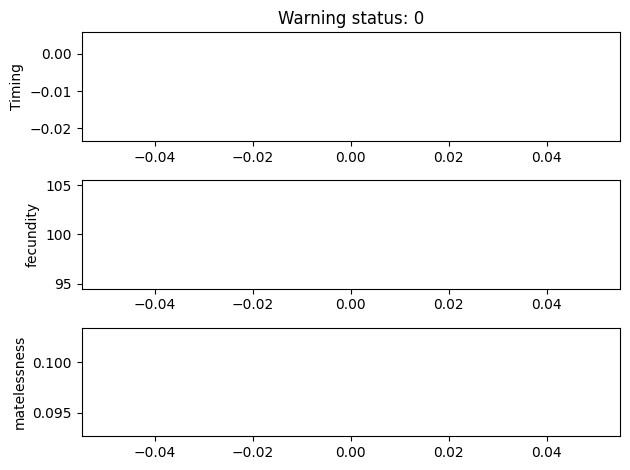

generation 1


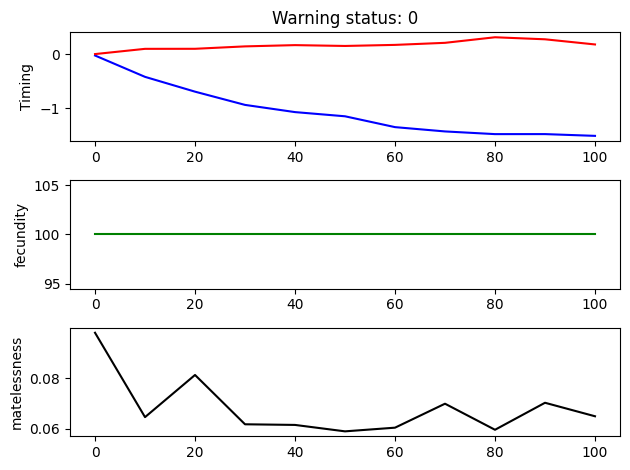

generation 101


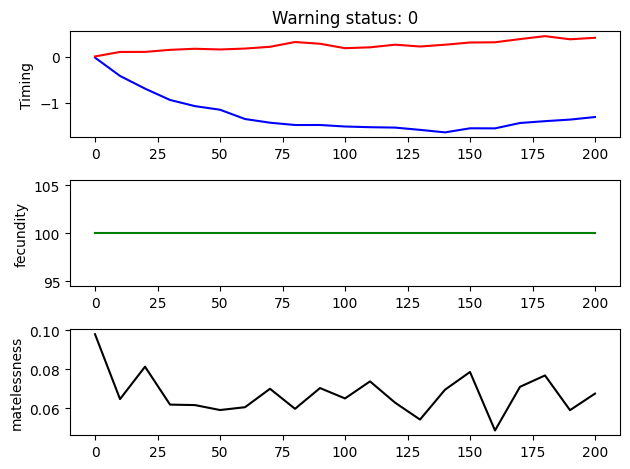

generation 201


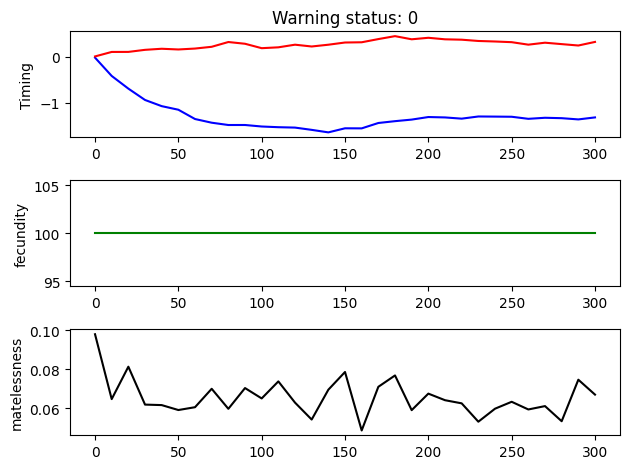

generation 301


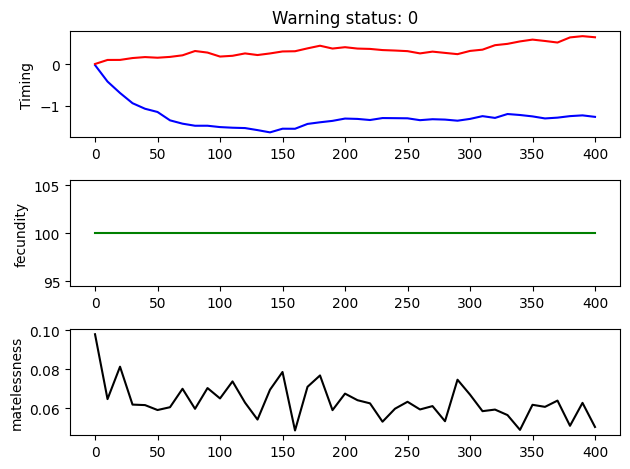

generation 401


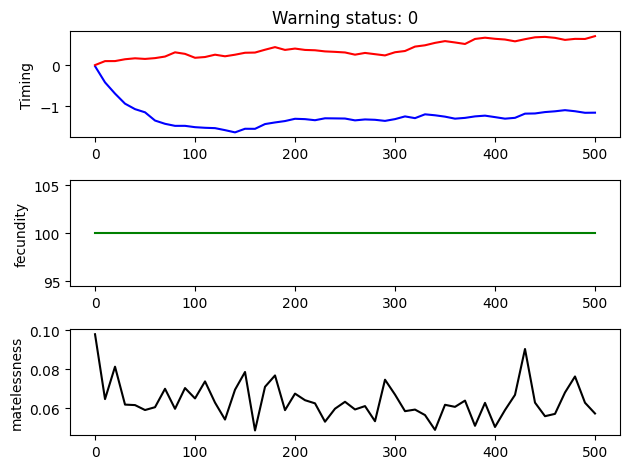

generation 501


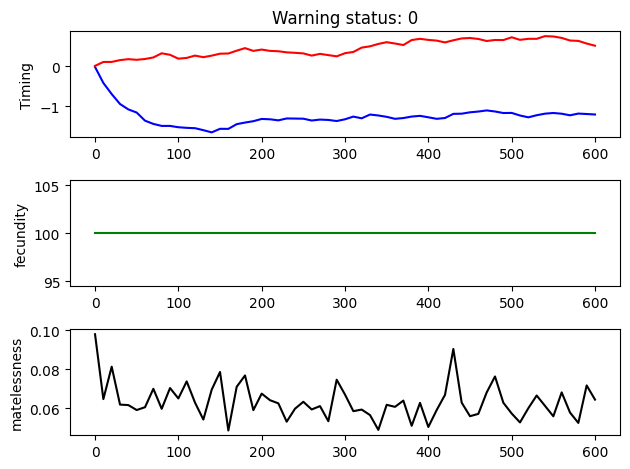

generation 601


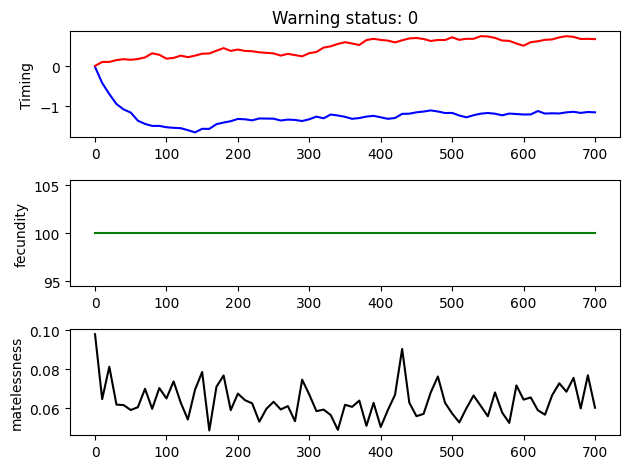

generation 701


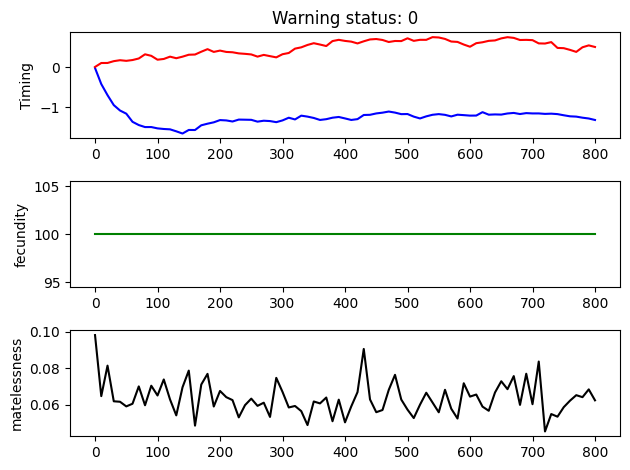

generation 801


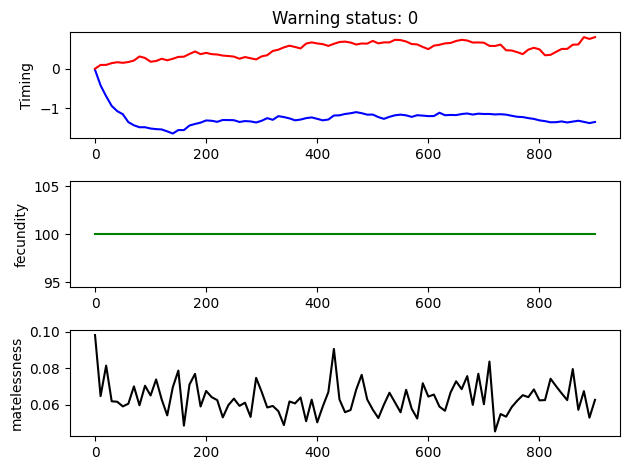

generation 901


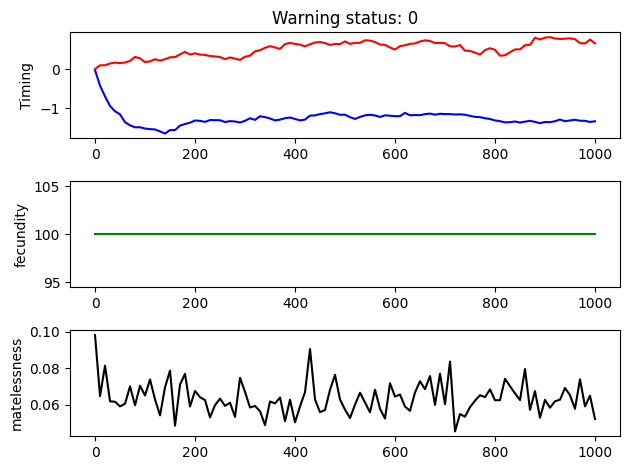

generation 1001


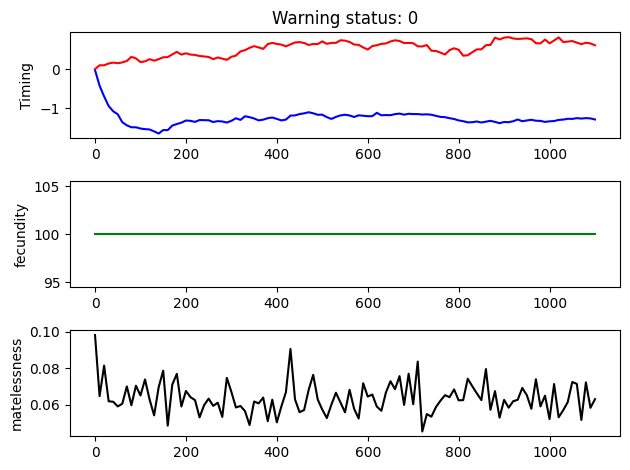

generation 1101


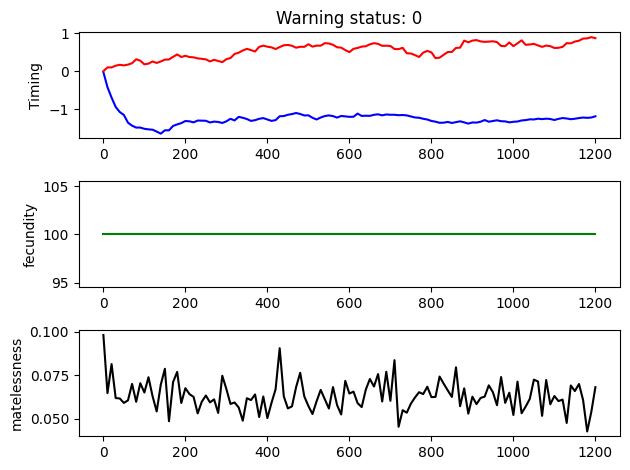

generation 1201


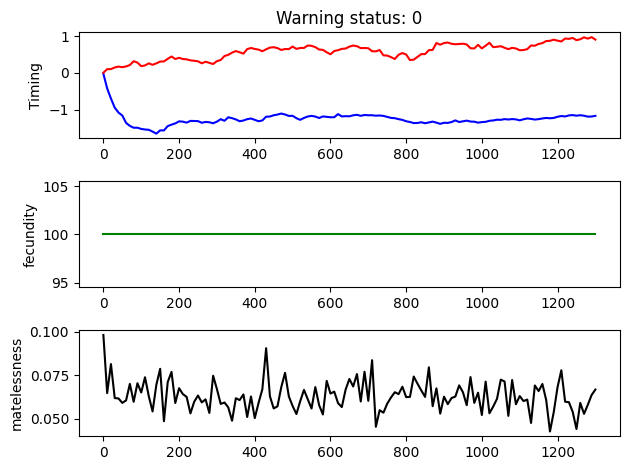

generation 1301


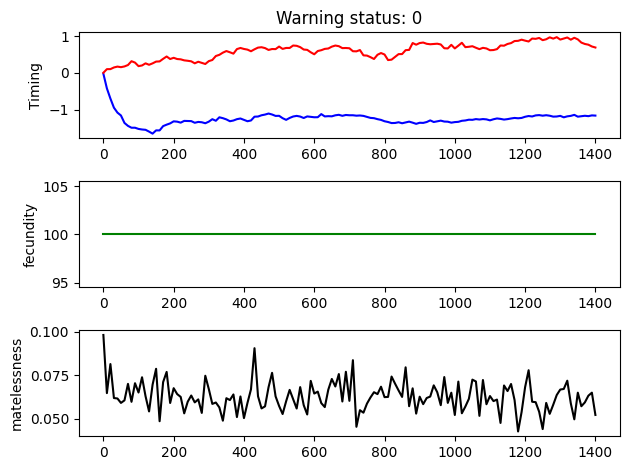

generation 1401


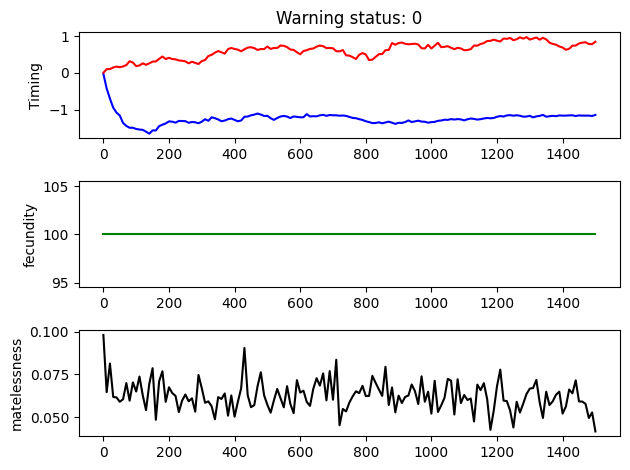

generation 1501


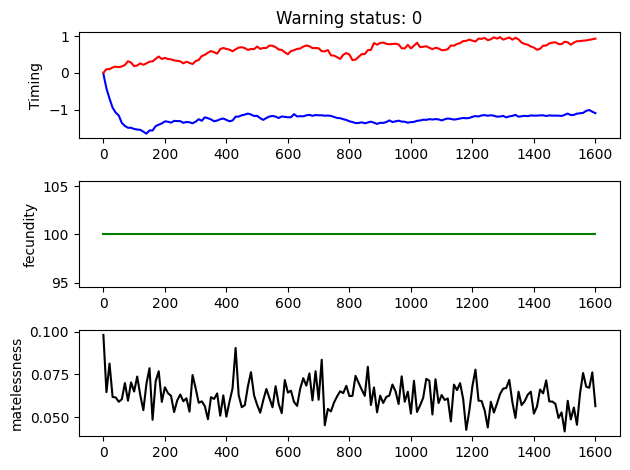

generation 1601


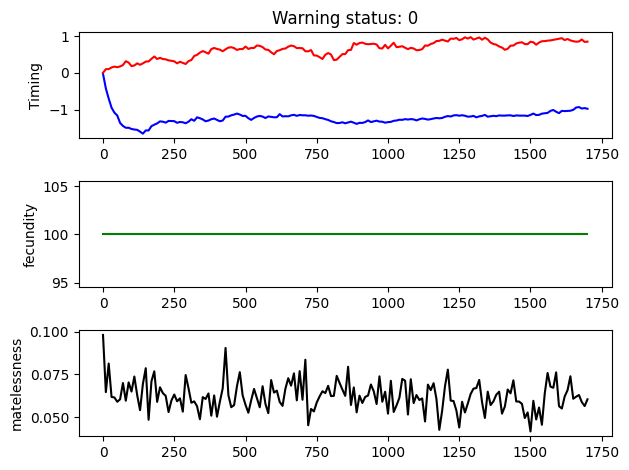

generation 1701


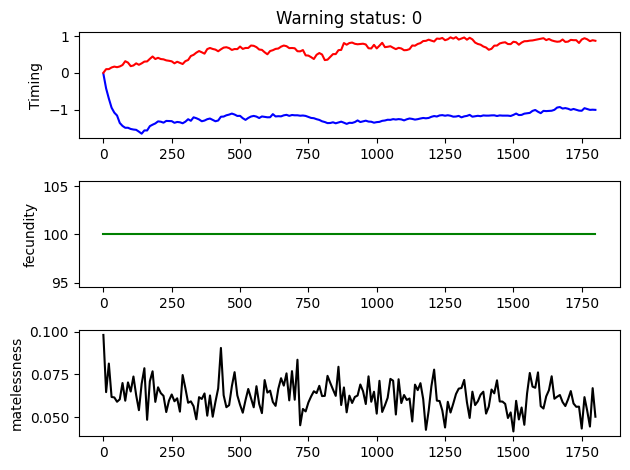

generation 1801


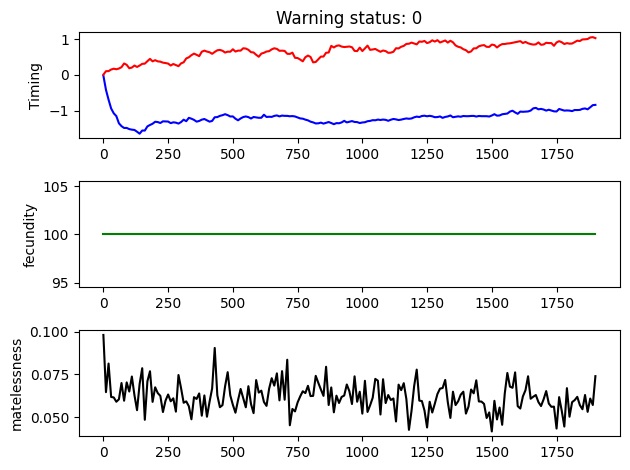

generation 1901


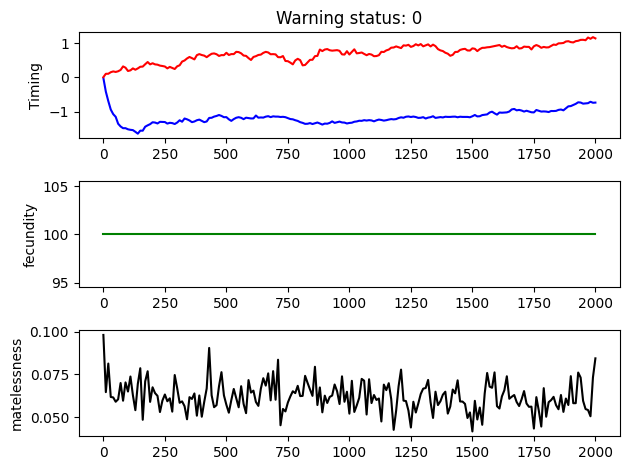

generation 2001


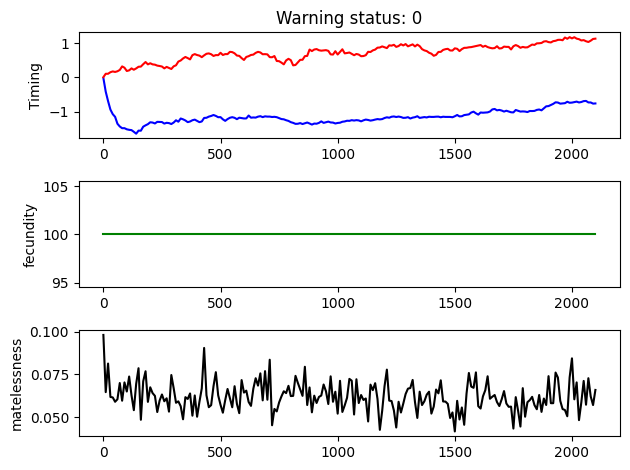

generation 2101


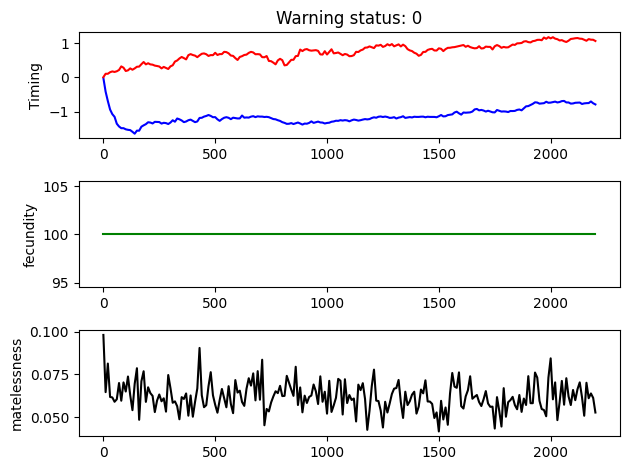

generation 2201


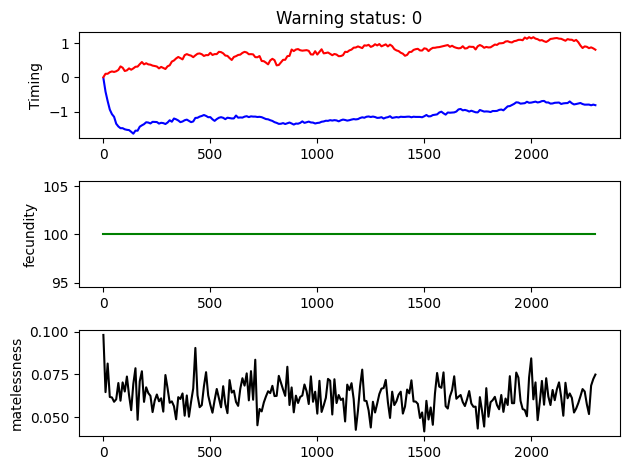

generation 2301


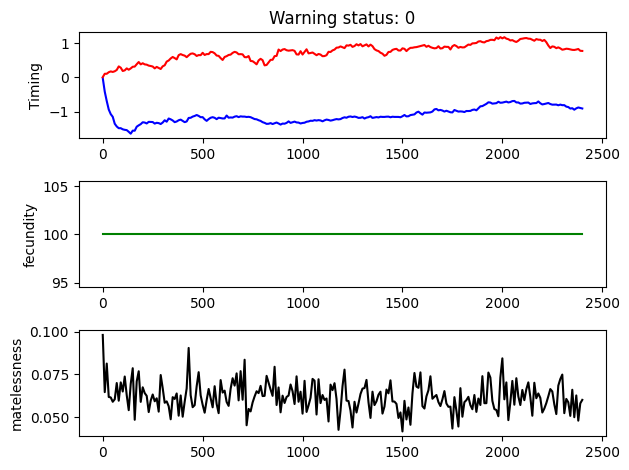

generation 2401


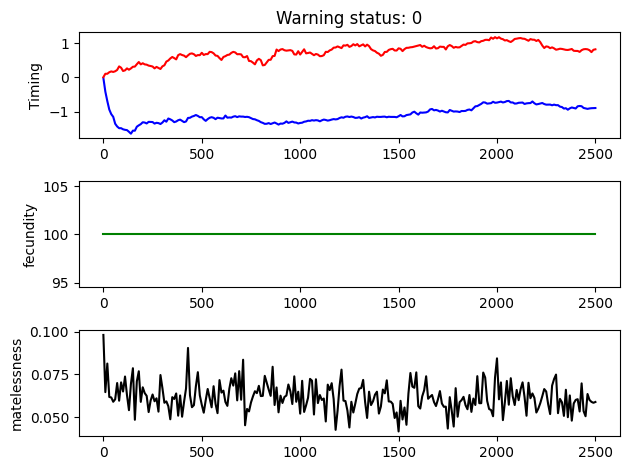

generation 2501


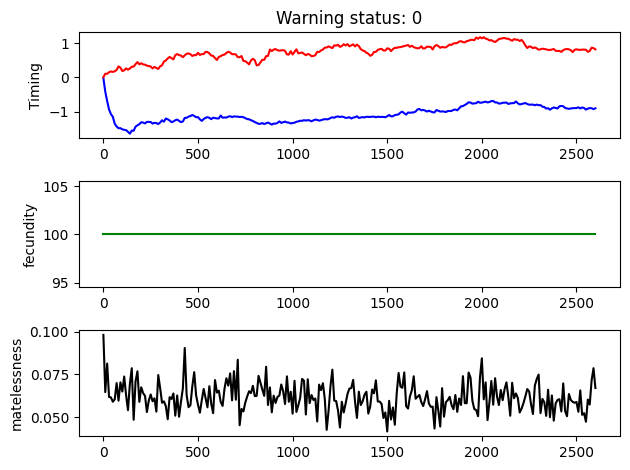

generation 2601


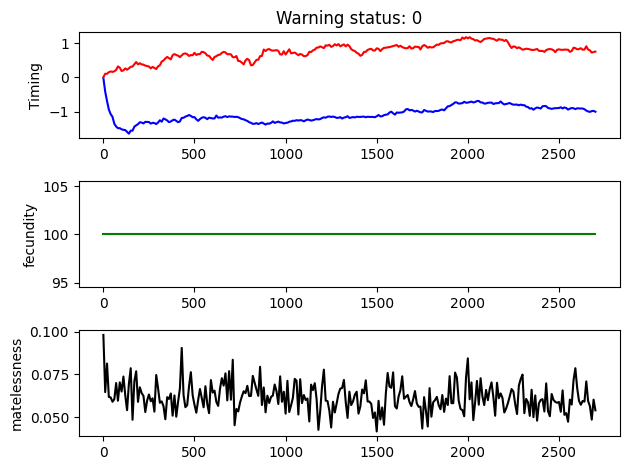

generation 2701


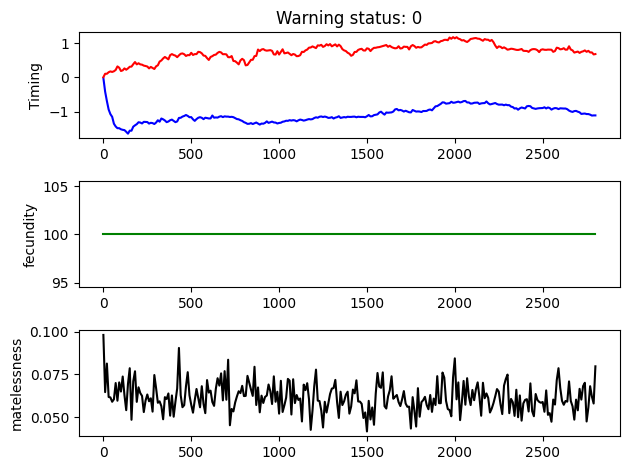

generation 2801


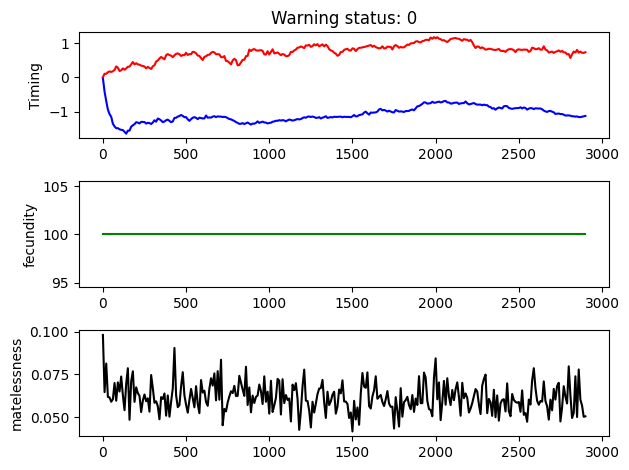

generation 2901


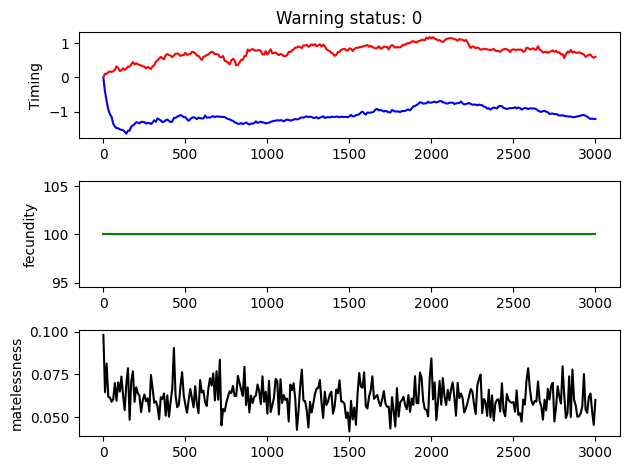

generation 3001


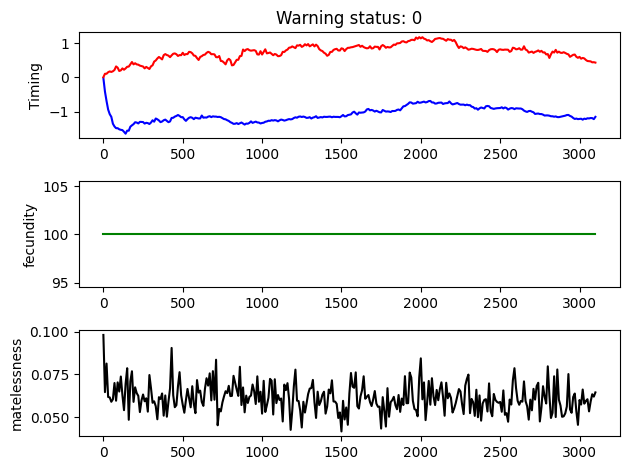

generation 3101


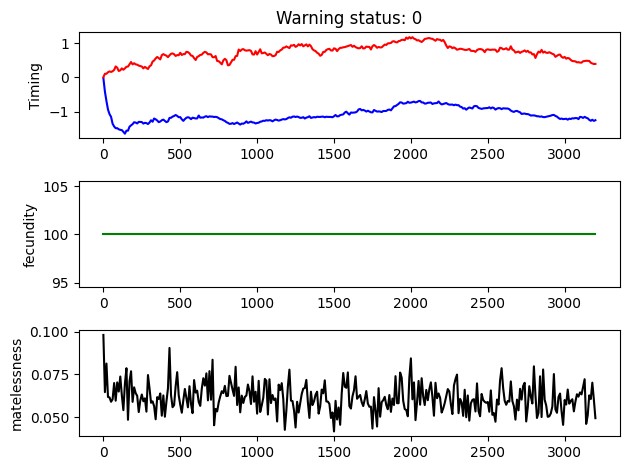

generation 3201


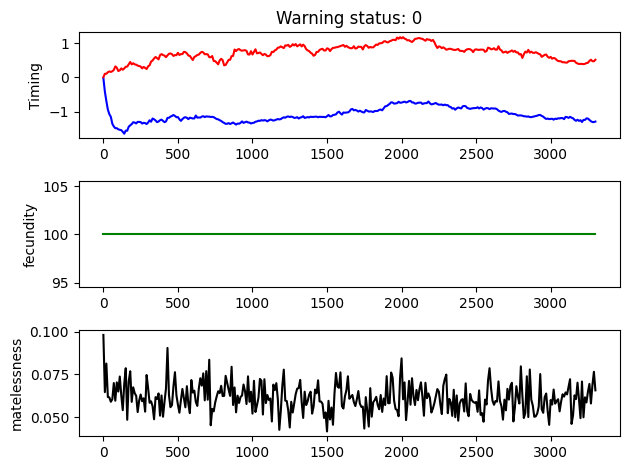

generation 3301


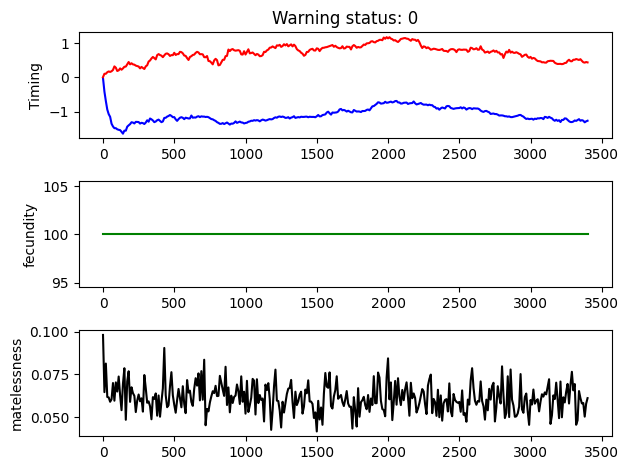

generation 3401


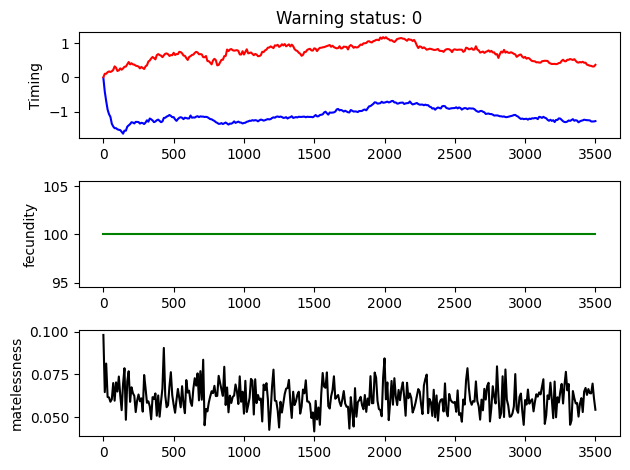

generation 3501


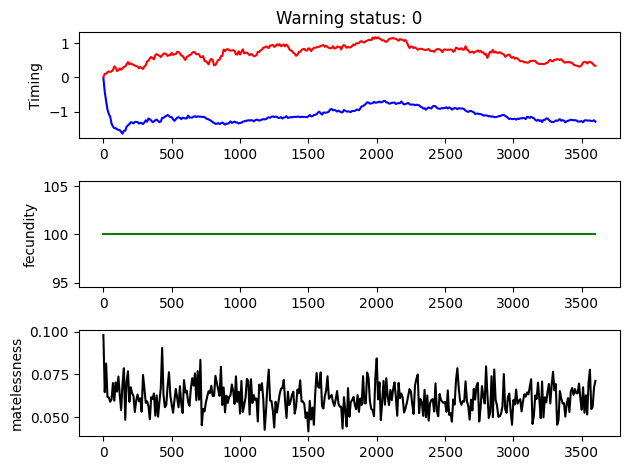

generation 3601


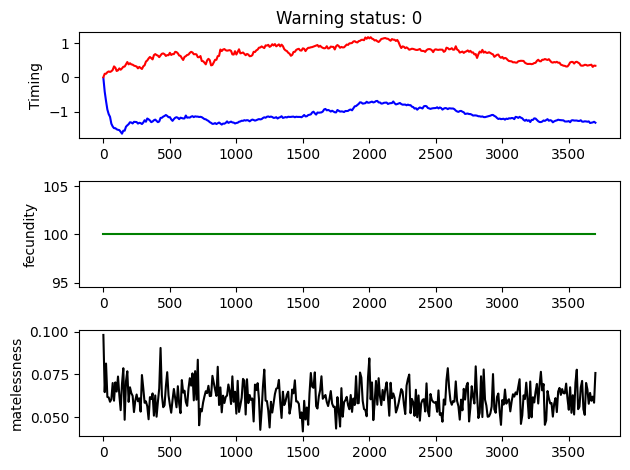

generation 3701


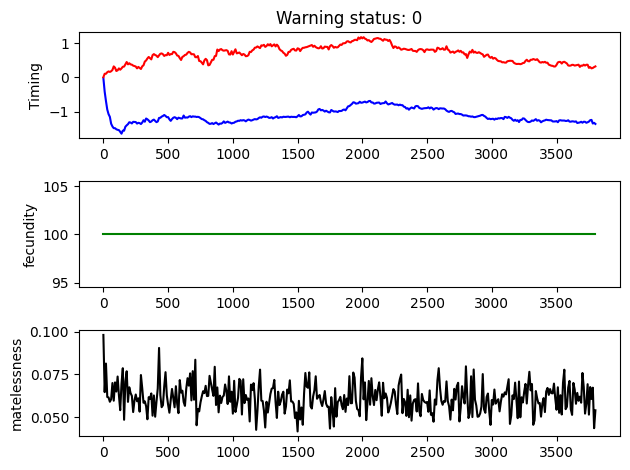

generation 3801


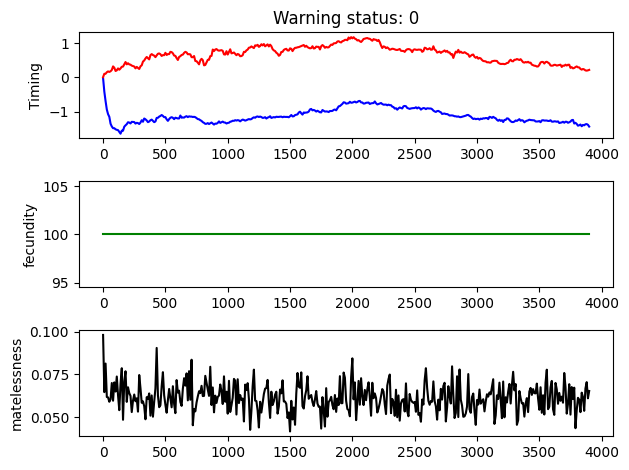

generation 3901


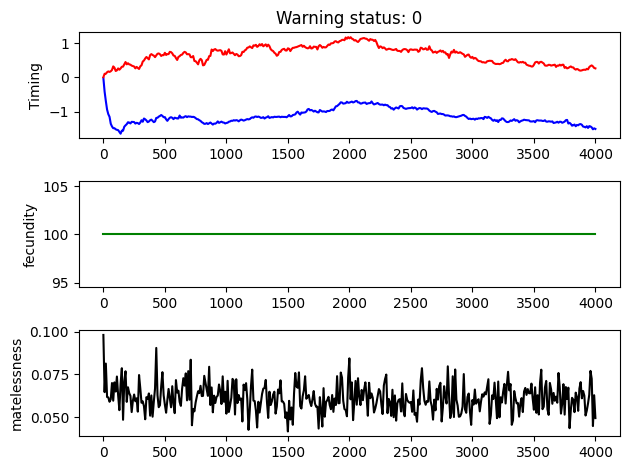

generation 4001


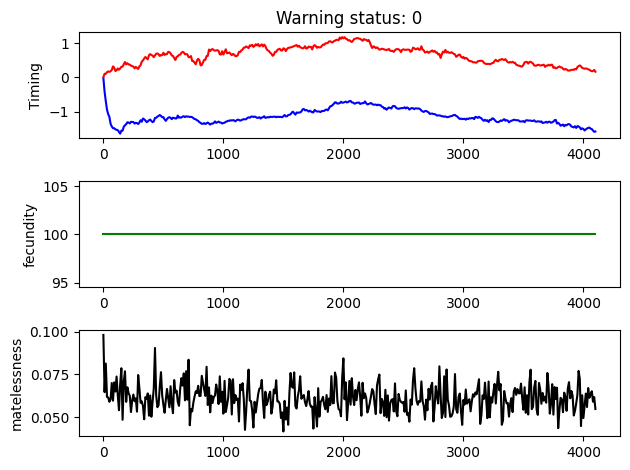

generation 4101


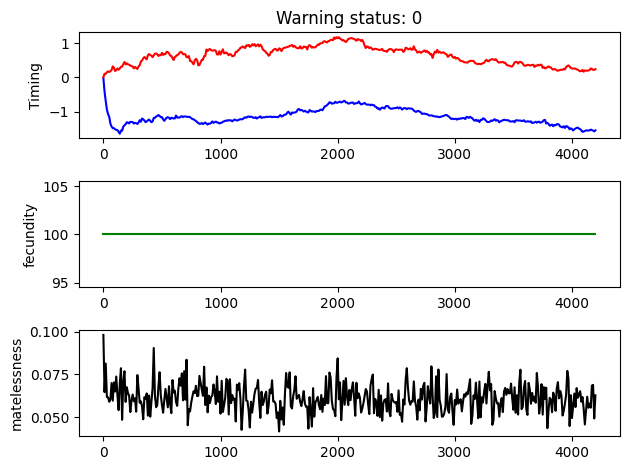

generation 4201


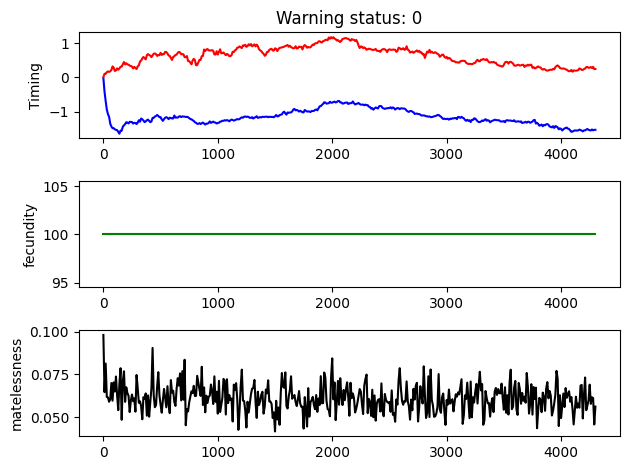

generation 4301


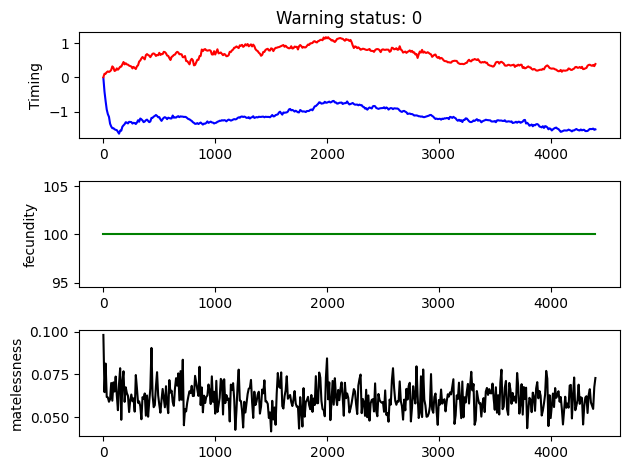

generation 4401


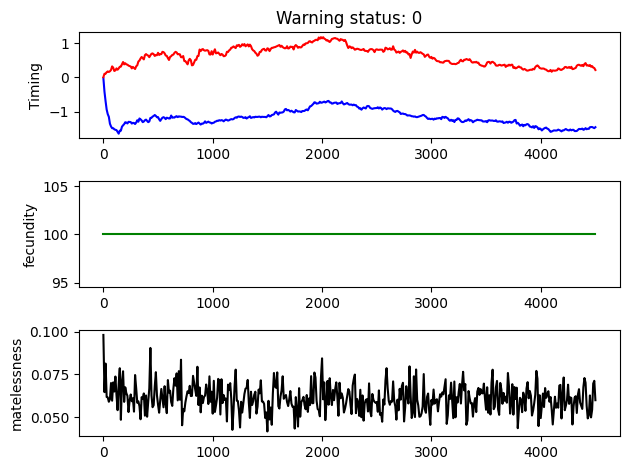

generation 4501


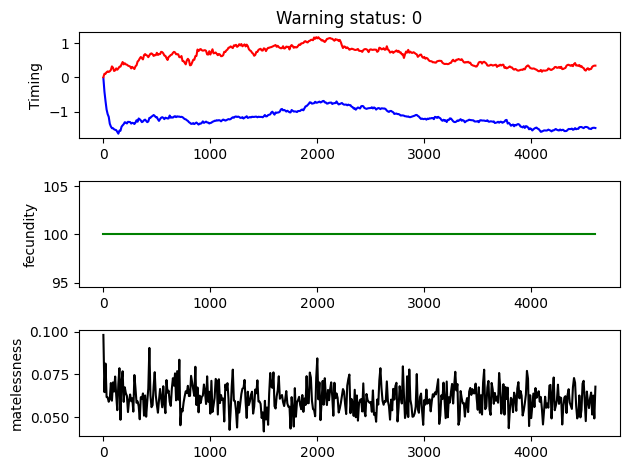

generation 4601


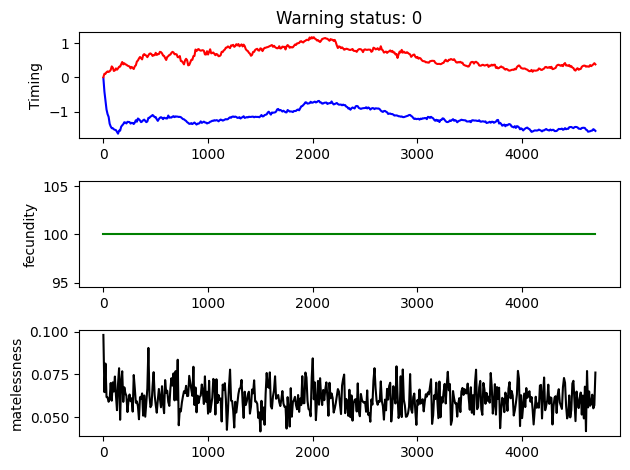

generation 4701


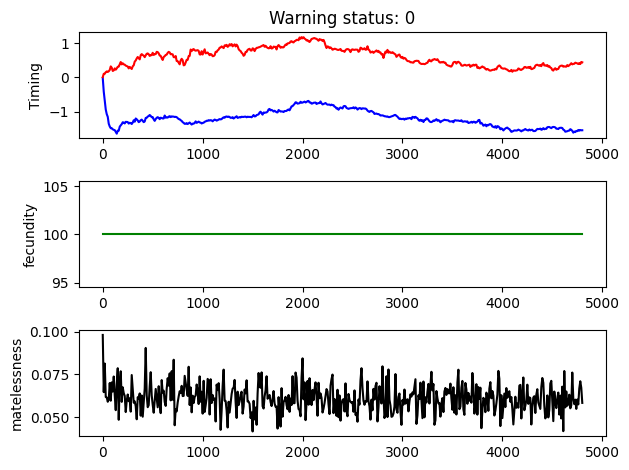

generation 4801


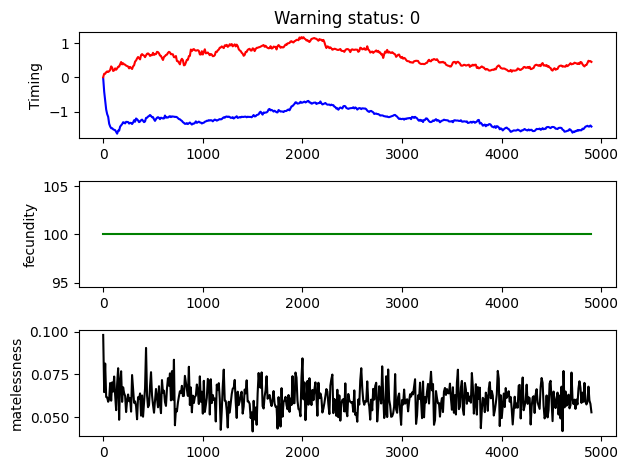

generation 4901


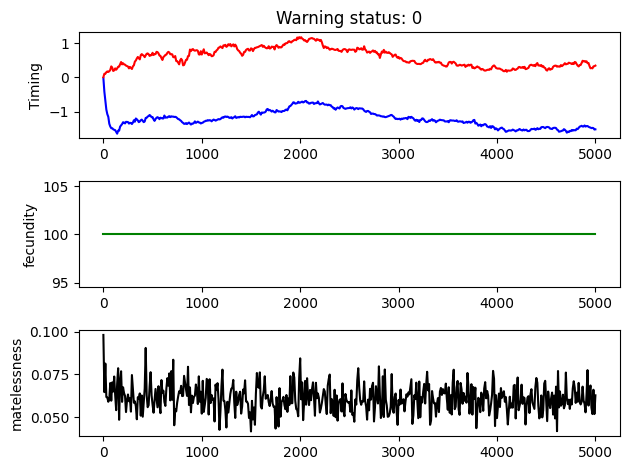

generation 5001


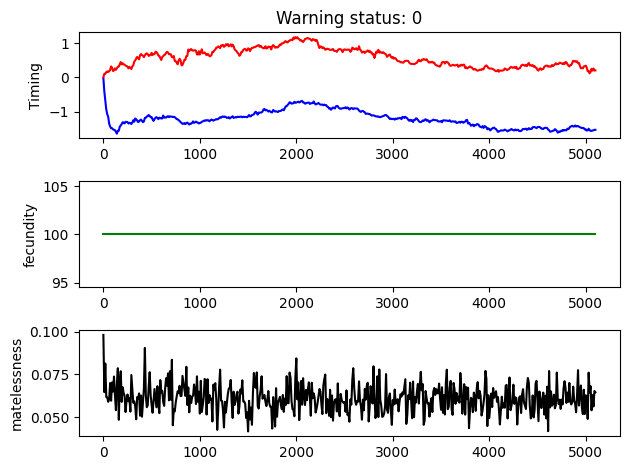

generation 5101


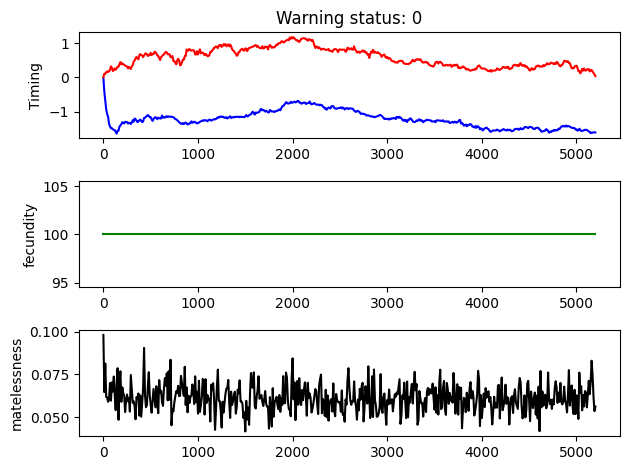

generation 5201


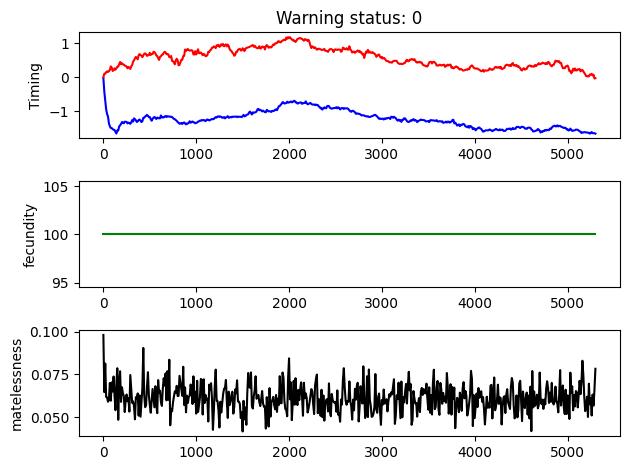

generation 5301


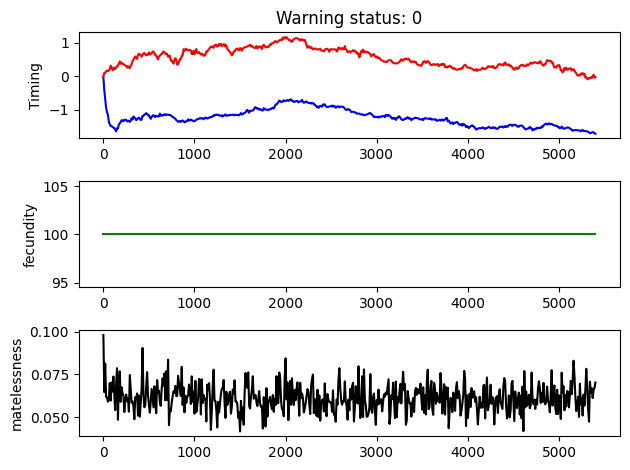

generation 5401


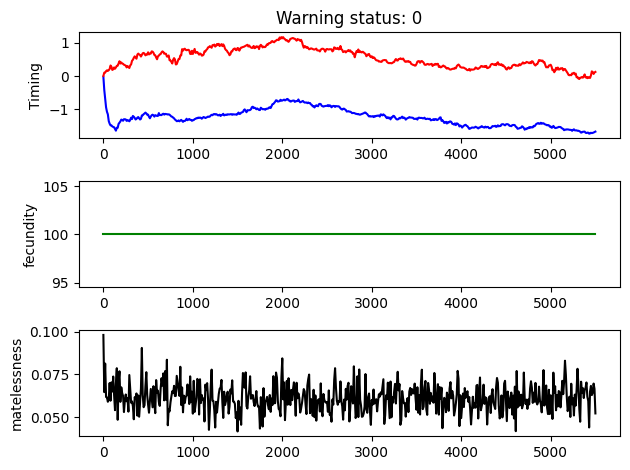

generation 5501


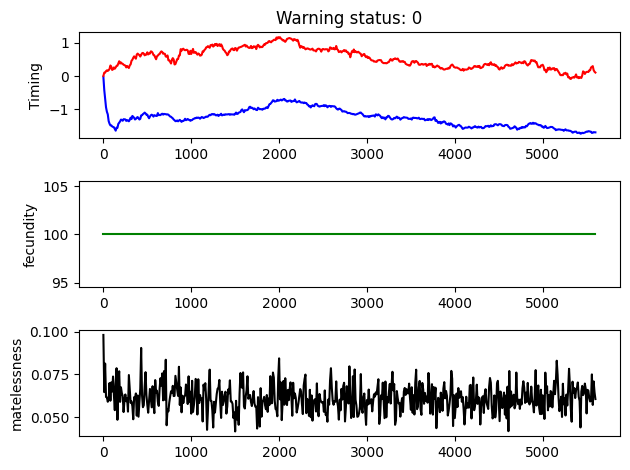

generation 5601


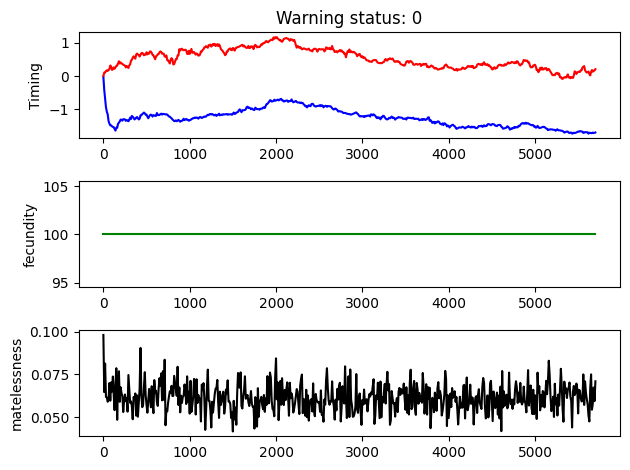

generation 5701


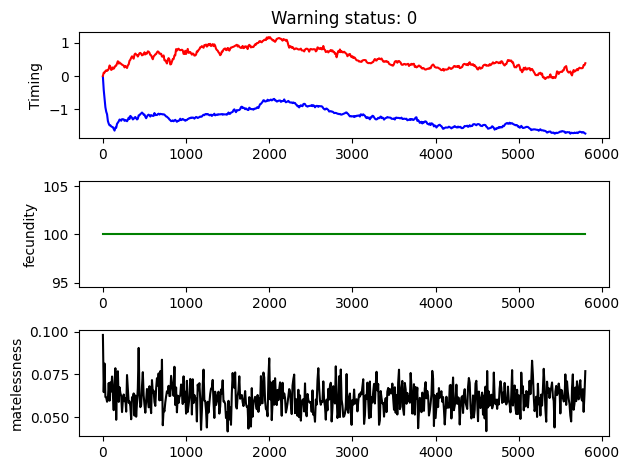

generation 5801


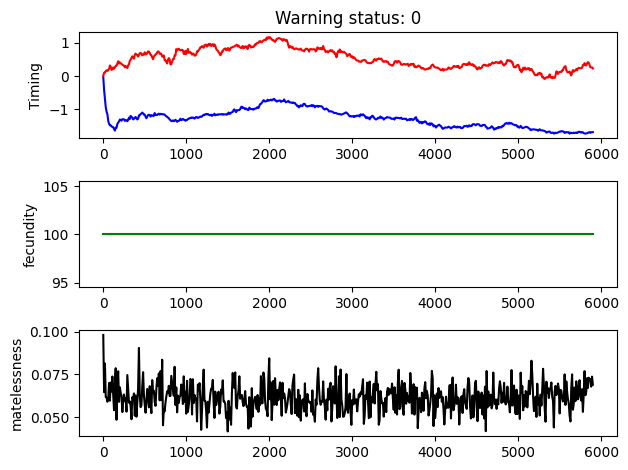

generation 5901


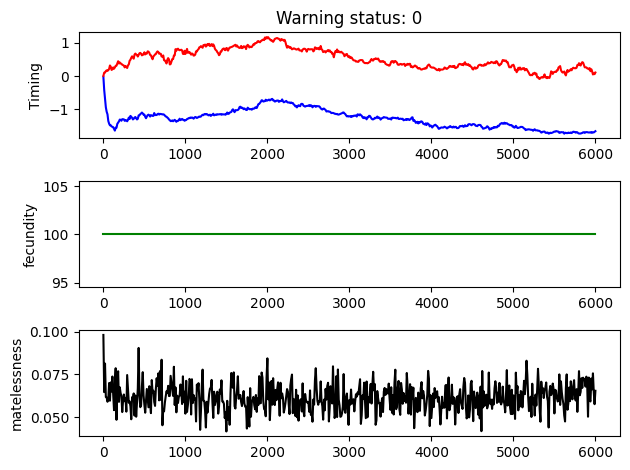

generation 6001


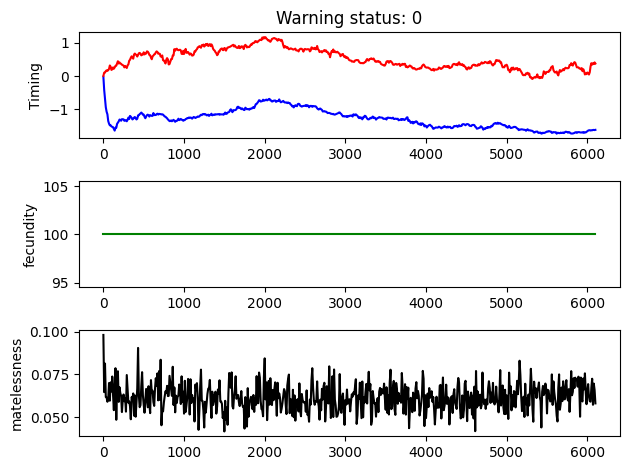

generation 6101


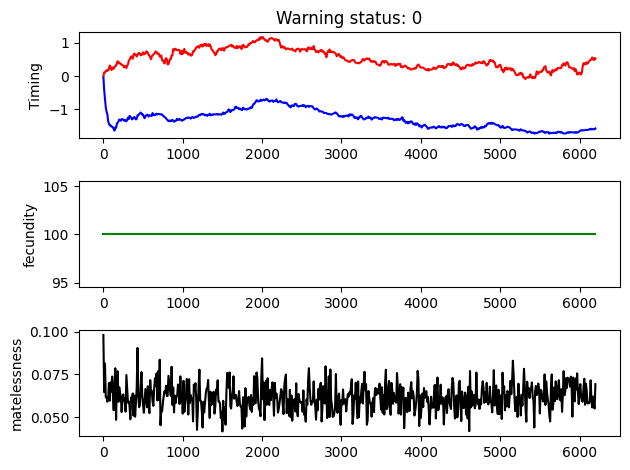

generation 6201


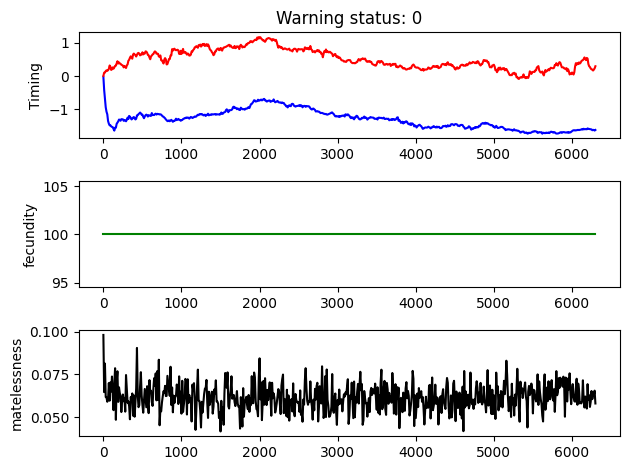

generation 6301


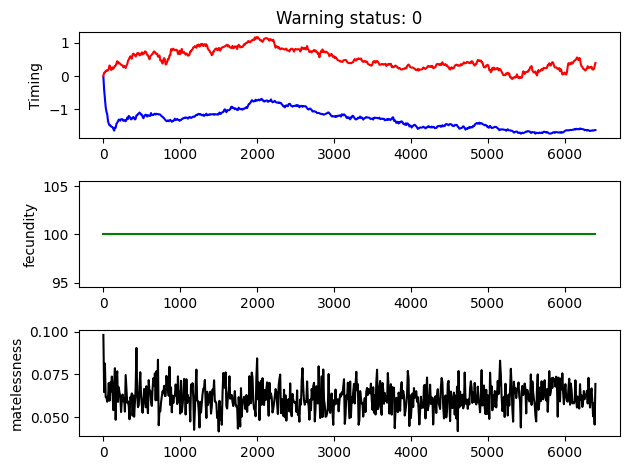

generation 6401


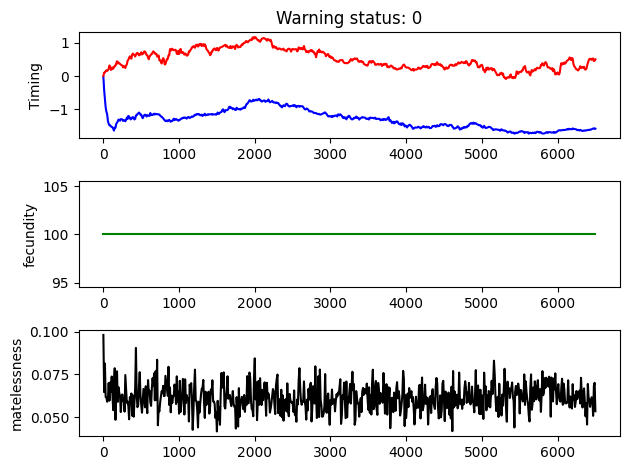

generation 6501


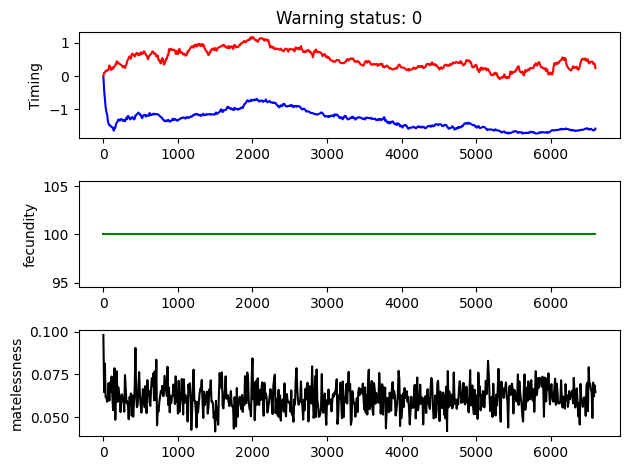

generation 6601


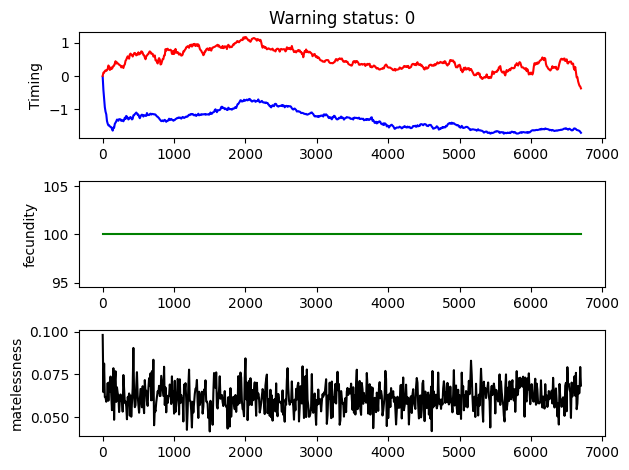

generation 6701


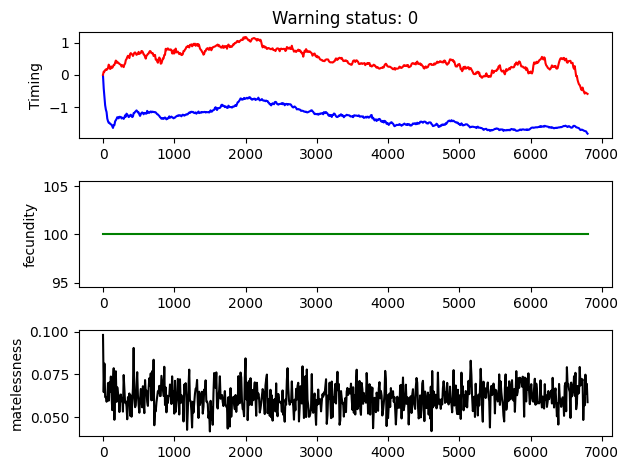

generation 6801


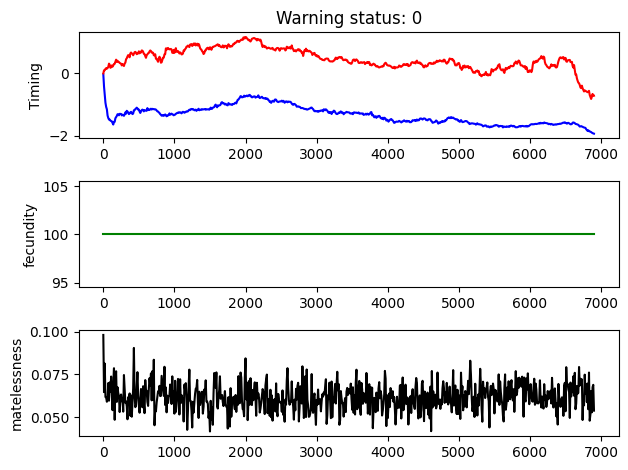

generation 6901


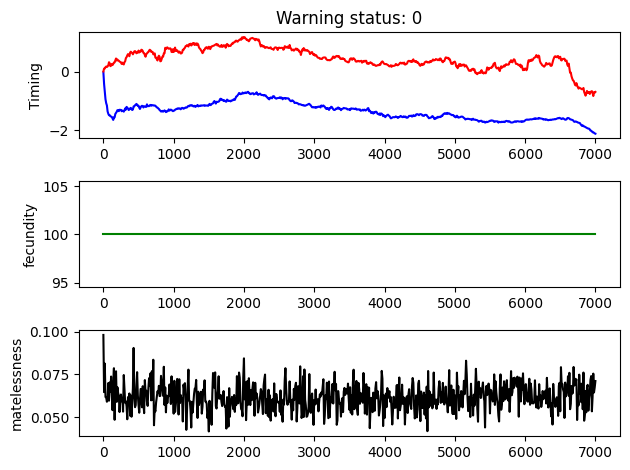

generation 7001


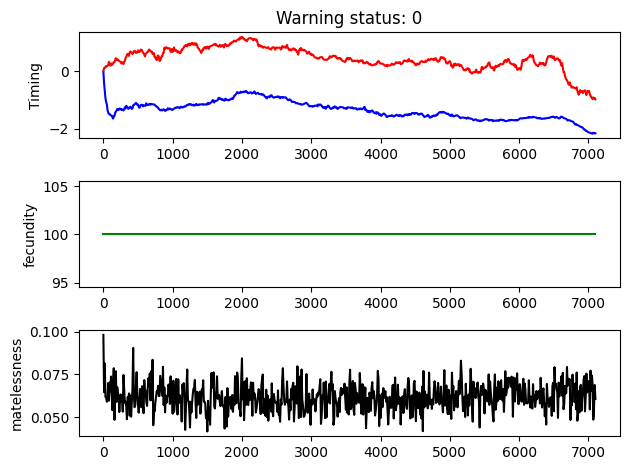

generation 7101


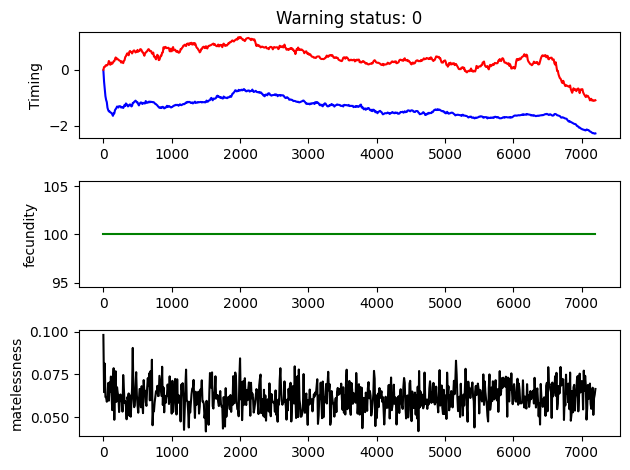

generation 7201


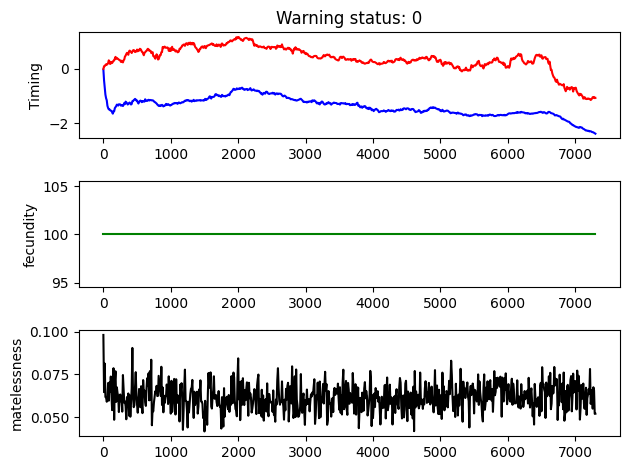

generation 7301


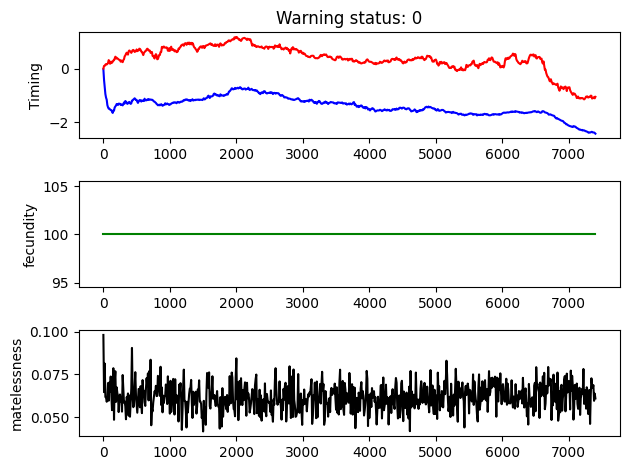

generation 7401


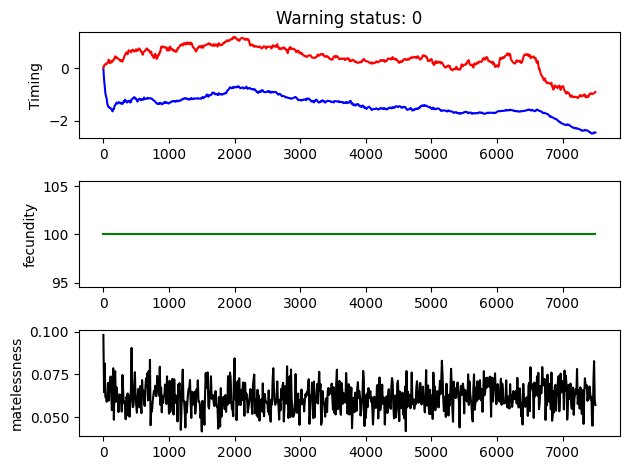

generation 7501


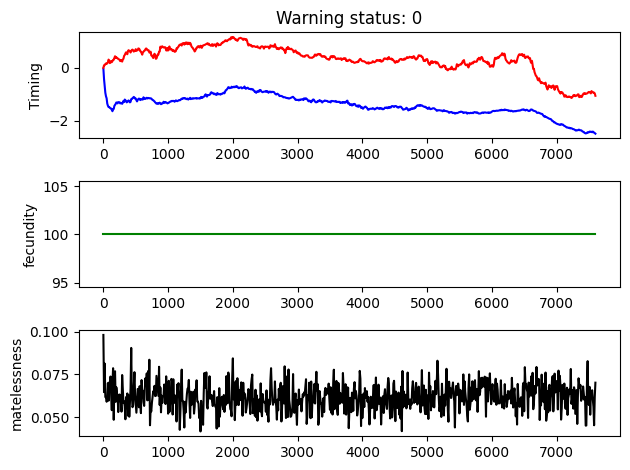

generation 7601


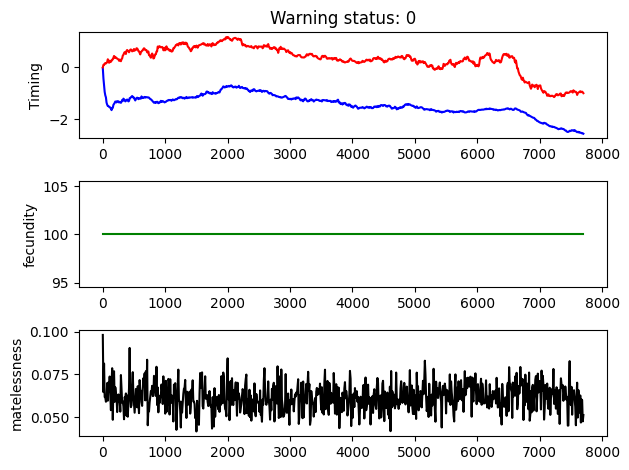

generation 7701


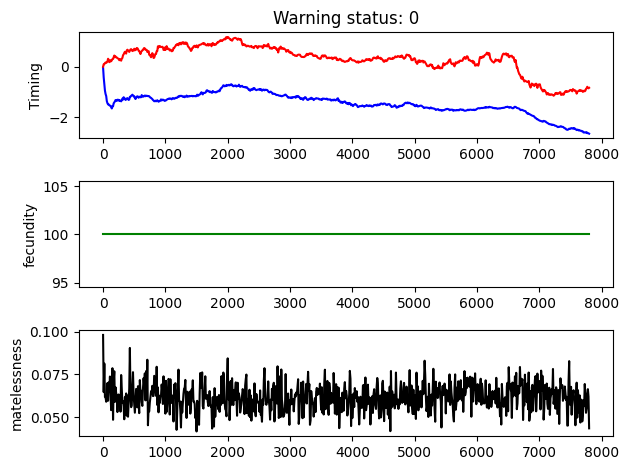

generation 7801


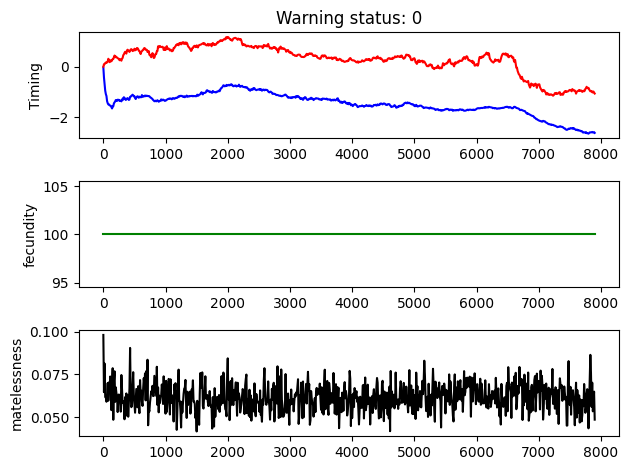

generation 7901


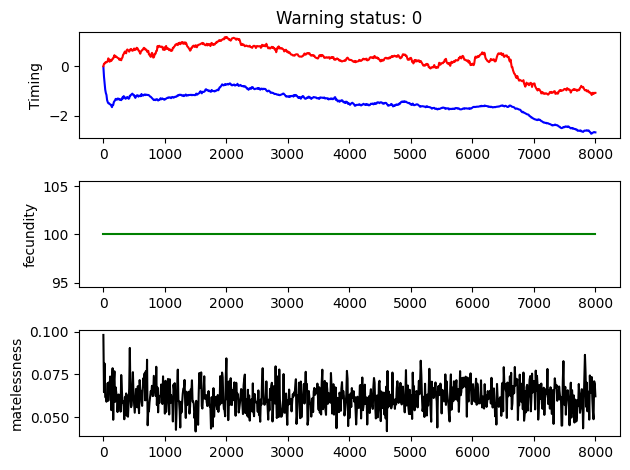

generation 8001


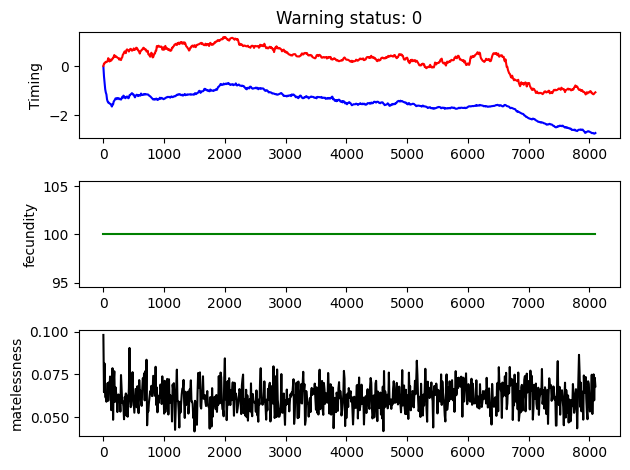

generation 8101


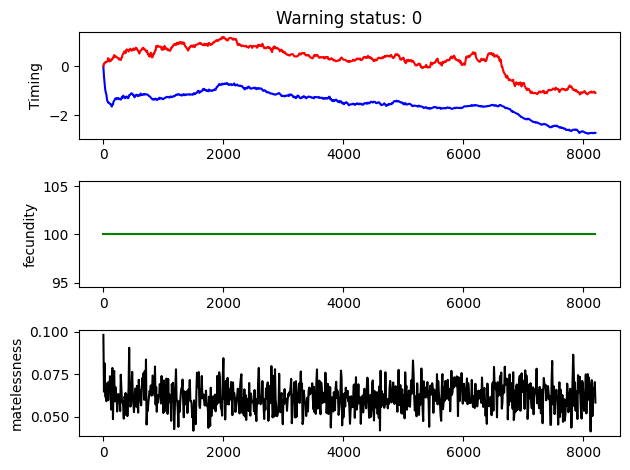

generation 8201


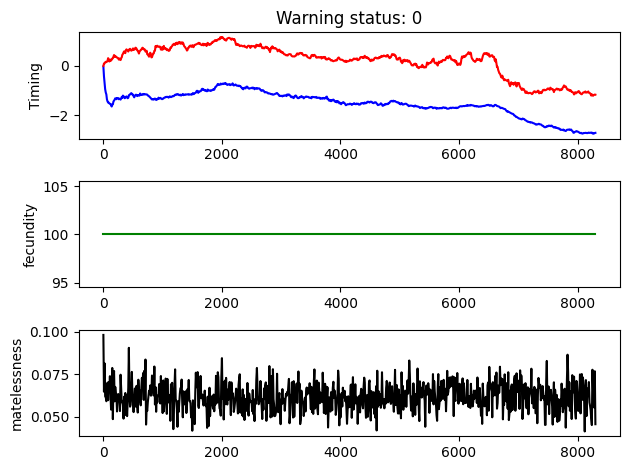

generation 8301


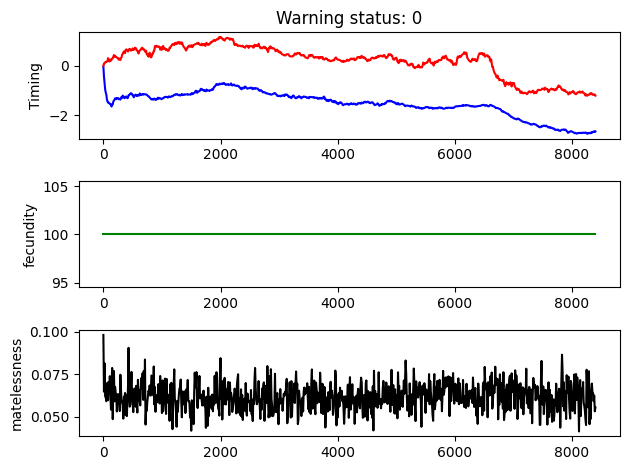

generation 8401


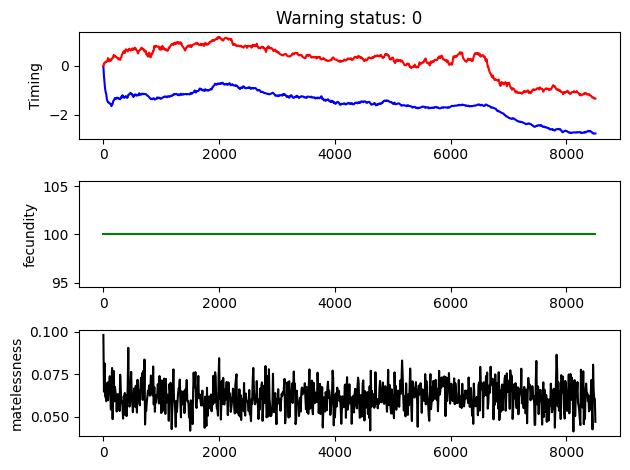

generation 8501


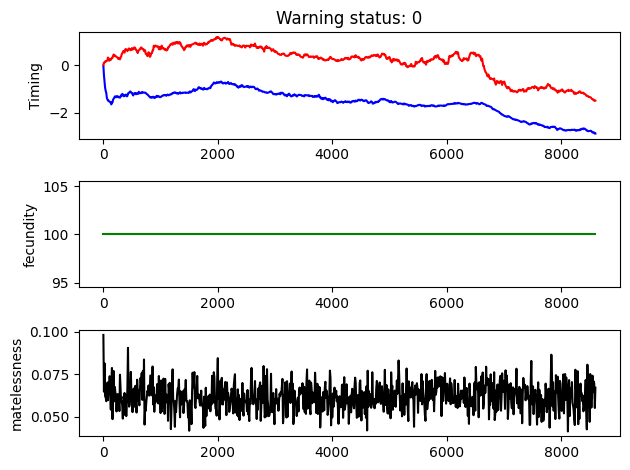

generation 8601


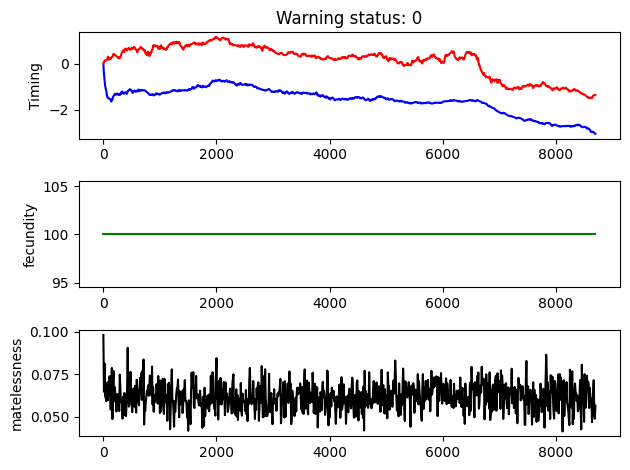

generation 8701


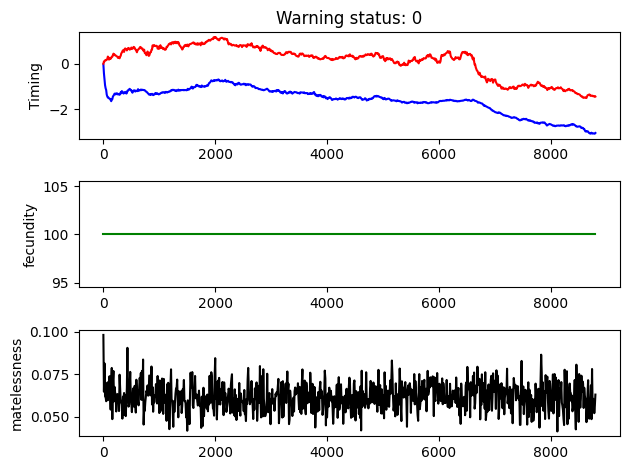

generation 8801


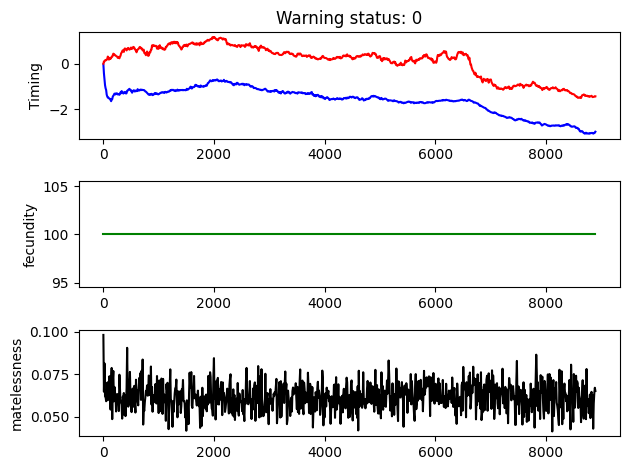

generation 8901


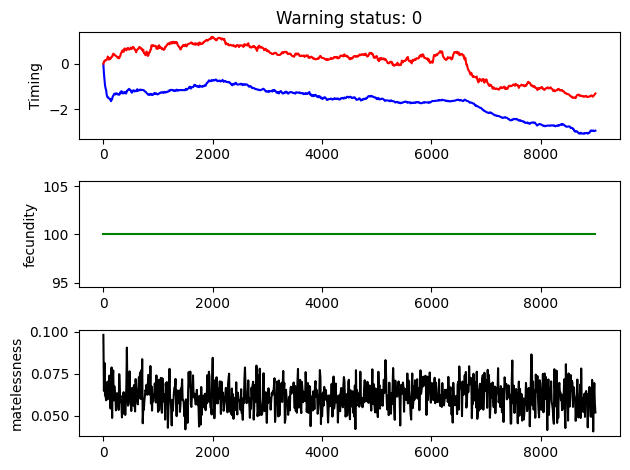

generation 9001


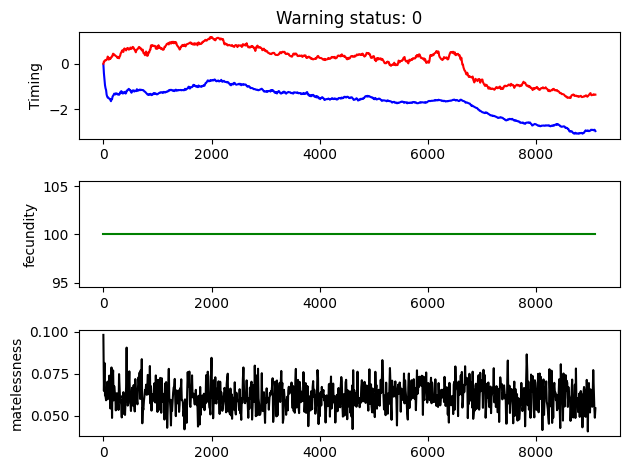

generation 9101


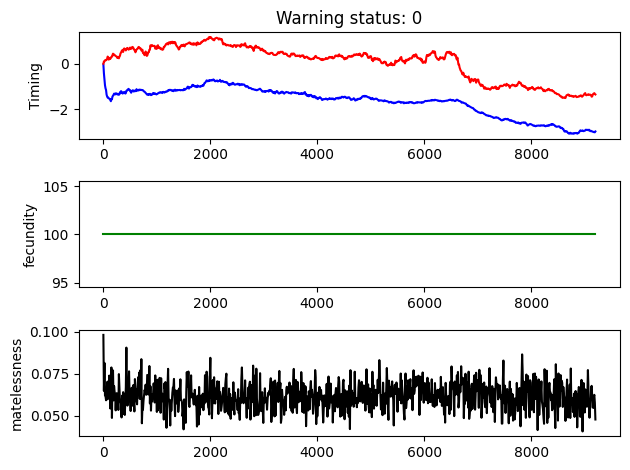

generation 9201


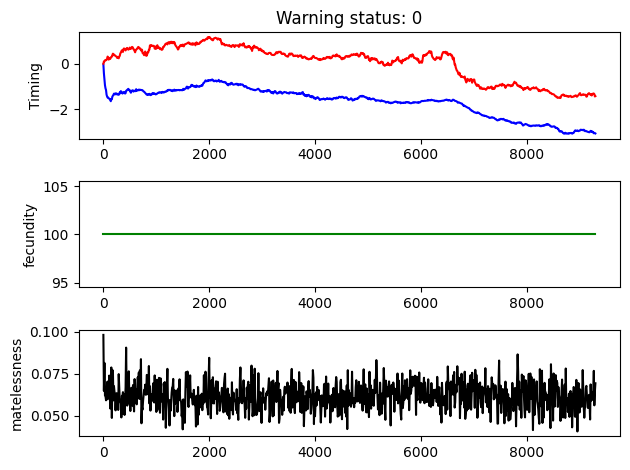

generation 9301


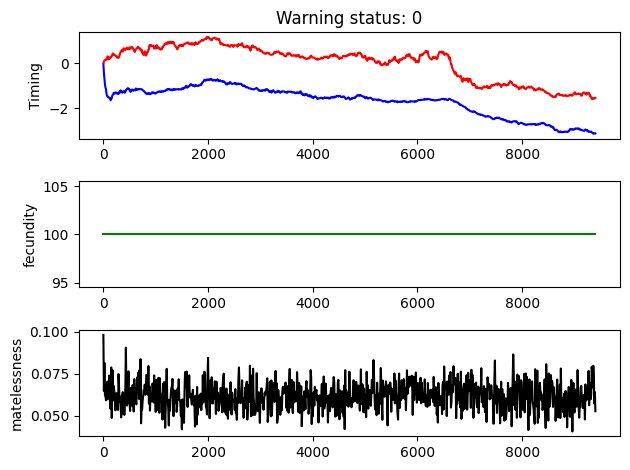

generation 9401


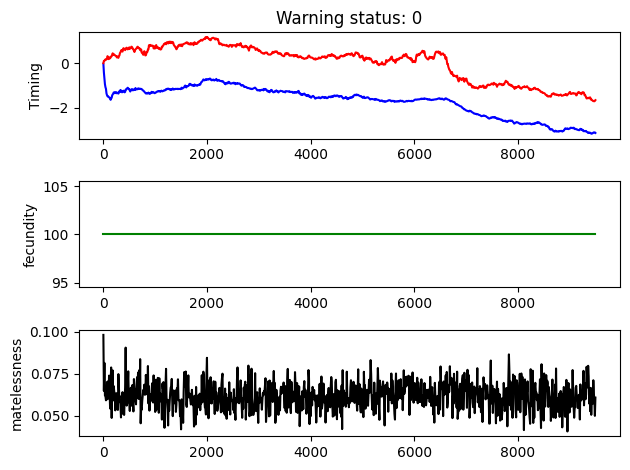

generation 9501


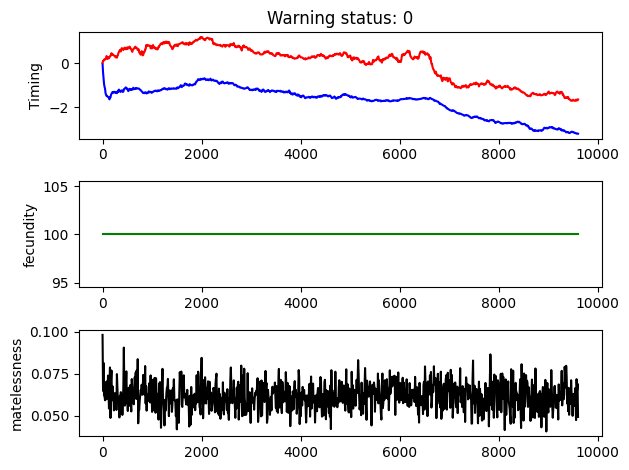

generation 9601


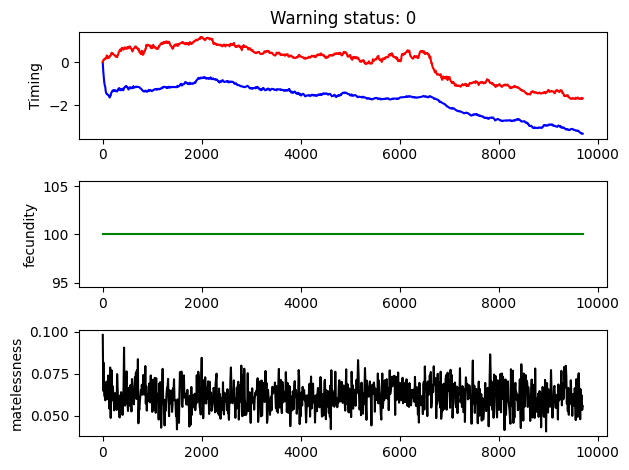

generation 9701


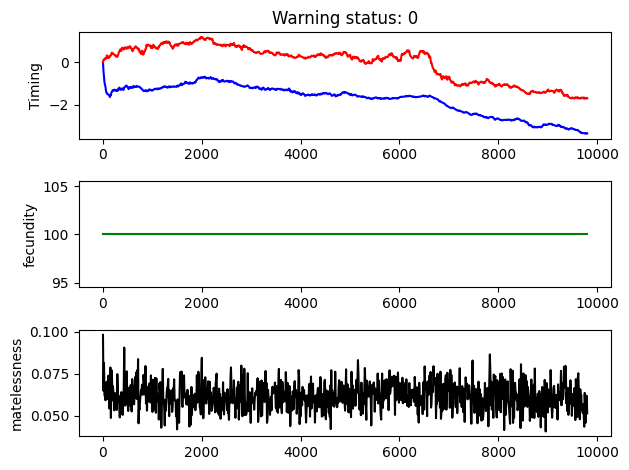

generation 9801


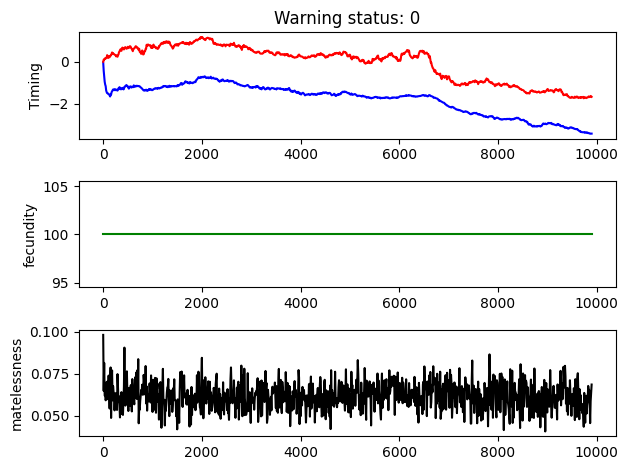

generation 9901


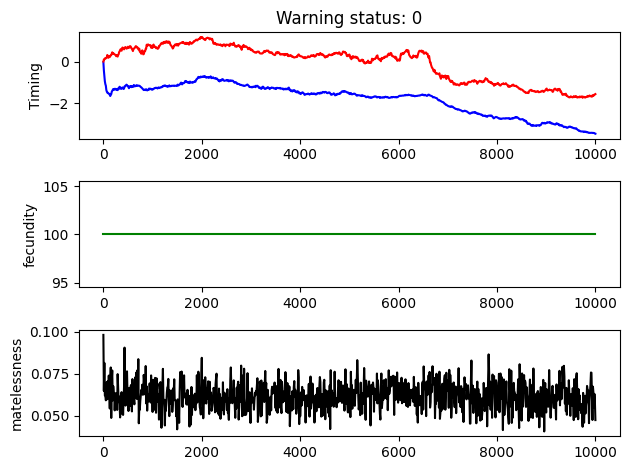

generation 10001


In [13]:
def run_simulation_for_k_generations(data):

    pop_initial = initialise_population(popsize, initmean, sa, ma, fa)

    for k in range(1, generations + 1):

        pop = pop_initial
        phenotype = population_phenotypes(pop)
        emergencetime = emergencesample(phenotype)
        deathtime = population_deathtime(emergencetime, pop)

        T_encounter, who_encounter, flag = track_encounter_for_population(pop, emergencetime, deathtime)
        mateidentity, relativefecundity, warning, extinction_status = mating_assignment_population(pop, T_encounter, who_encounter, flag)    


        if extinction_status == 1:
            break
        
        if (k-1)/10==math.floor((k-1)/10):
            data = data_collection(data, k, pop, relativefecundity, mateidentity)

            if (k-1)/100== math.floor((k-1)/100):
                
                print(data)
                plotting(data, warning, k)
        
        pop_next_gen = offspring_population(pop, mateidentity, relativefecundity)
        pop = pop_next_gen


run_simulation_for_k_generations(data)
# print(data, "data")
# print("generation over, onto next")



    

# print('----final---')
